# Tasmanian Devil Parameter Fitting
Parameter fitting for Tasmanian Devil parameters pre-DFTD

In [1]:
import os
import sys
sys.path.insert(1, os.path.abspath(os.path.join(os.getcwd(), '../GillesPy2')))

In [2]:
import math
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition, mark_inset)

## Read in observed data

In [3]:
pop_data = pd.read_csv('Devils_Dataset__Population_1985-2020.csv')

devil_pop = np.array(pop_data['Population'].iloc[:].values)
dates = []
year = 1985
while len(dates) < len(devil_pop):
    for month in ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sept", "Oct", "Nov", "Dec"]:
        dates.append(f"{month} {year}")
    year += 1

obs = np.vstack([devil_pop]).reshape(1, 1, -1)
carry_cap = int(max(devil_pop)*1.16)

## Load Simulation data and Paramter Sweeps

In [4]:
with open('figure_data/Fig3A_Fig14A-data.p', 'rb') as fd:
    sim_data = pickle.load(fd)
    
    variables = sim_data['variables']
    sweeps = sim_data['sweeps']
    eresults = sim_data['eresults']
    mean_std_db = sim_data['mean_std_db']

## Plotting functions and helpers

In [5]:
def make_filename(variables):
    cmdpath = "ParameterSweeps/tmp_result_state"
    ret = 'ps-'
    for key in sorted(variables.keys()):
        value = float(variables[key])
        ret += f"{value:.4e},"
    return os.path.join(cmdpath, ret)

In [6]:
def get_mean_std(var):
    f = make_filename(var)
    if f in mean_std_db:
        return mean_std_db[f]

In [7]:
def plot_eresult(eresults): 
    fig, ax1 = plt.subplots(figsize=[12, 6])

    plt.title("Tasmanian Devil Population with DFTD: Observed vs. Simulated", fontsize=18)
    ax1.set_xlabel(f"Time (months) since {dates[0]}", fontsize=16)
    ax1.set_ylabel("Population of Tasmanian Devils", fontsize=16)
    ax1.plot(eresults[0]['time'], obs[0][0], '--', color='black', label='Observed Total')
    ax1.plot(eresults[0]['time'], eresults[0]['Devils'], color='blue', label='Simulated Total')
    ax1.plot(eresults[0]['time'], eresults[0]['Juvenile'], color='purple', alpha=.6, label='Juvenile')
    ax1.plot(eresults[0]['time'], eresults[0]['Susceptible'], color='green', alpha=.6, label='Susceptible')
    ax1.plot([variables['DFTD_start'], variables['DFTD_start']], [-3000, carry_cap], '--k', alpha=0.4)
    ax1.text(variables['DFTD_start']-7, 5000, "DFTD Start", rotation="vertical", color="black", fontsize=14)
    ax1.text(variables['DFTD_start']-7, 24000, dates[variables['DFTD_start']], rotation="vertical", color="black", fontsize=14)
    ax1.tick_params(axis='x', labelsize=12)
    
    x_ticks = list(range(0, 421, 60))
    x_ticklabels = []
    for i in x_ticks:
        x_ticklabels.append(dates[i])

    ax1.set_xticks(x_ticks)
    ax1.set_xticklabels(x_ticklabels)
    ax1.set_yticks([20000,40000,60000])
    ax1.tick_params(axis='y',labelsize=12, labelrotation=90)
    ax1.legend(loc='upper right', fontsize=16)
    ax1.set_ylim([0, carry_cap])
    ax1.set_xlim(0,eresults[0]['time'][-1])
    for n,r in enumerate(eresults):
        if n==0: continue
        ax1.plot(eresults[n]['time'], eresults[n]['Devils'],'b', alpha=0.025)
        ax1.plot(eresults[n]['time'], eresults[n]['Juvenile'], color='purple', alpha=0.025, label='Juvenile')
        ax1.plot(eresults[n]['time'], eresults[n]['Susceptible'], color='green', alpha=0.025, label='Susceptible')

    print(variables)
    
    def calculate_distance(eresults):
        '''return mean/stddev of L2 norm distance'''
        global obs
        dists = np.zeros(len(eresults))
        for n,r in enumerate(eresults):
            dists[n] = np.linalg.norm(r['Devils']-obs[0][0],2)
        return np.average(dists), np.std(dists)

    dist_l2 = calculate_distance(eresults)
    print(f"L2 = {dist_l2[0]:.2f} +/-{dist_l2[1]:.2f}")

In [8]:
def plot_sweep(name, nrows, ncols, nplots, ymax, my_yticks):
    global pltcnt
    xvals = np.zeros(len(sweeps[name]))
    mvals = np.zeros(len(sweeps[name]))
    svals = np.zeros(len(sweeps[name]))
    
    for n, v in enumerate(sweeps[name]):
        c = variables.copy()
        c[name] = float(v)
        try:
            (m, s) = get_mean_std(c)
            xvals[n] = c[name]
            mvals[n] = m
            svals[n] = s
        except Exception as e:
            print(f"caught e={e} while name={name}")
    
    ax1 = plt.subplot(nrows, ncols, nplots)
    ax1.errorbar(xvals, mvals, yerr=svals, capsize=10)
    ax1.plot([variables[name], variables[name]], [0, 100000], '--')
    ax1.text(float(sweeps[name][-1]), 10000, name, fontsize=16, ha='right')
    ax1.set_ylim(0, ymax)
    if pltcnt%2==1:
        ax1.set_ylabel('Error', fontsize=14)
        ax1.set_yticks(my_yticks)
        ax1.tick_params('y', labelsize=14, labelrotation=90)
    else:
        ax1.set_yticks([])
    ax1.tick_params('x', labelsize=14)

## Run Parameter Sweep

In [9]:
variables

{'juvenile_concentration': 0.49534348836011316,
 'birth_rate': 0.055,
 'maturity_rate': 0.04,
 'death_rate_juvenile': 0.007,
 'death_rate_over_population': 2.3e-07,
 'death_rate_susceptible': 0.02335,
 'incubation': 10.25,
 'progression': 10.74,
 'infection_rate_diseased': 3.84e-05,
 'infection_rate_infected': 1e-05,
 'death_rate_diseased': 0.29017,
 'death_rate_infected': 0.022609,
 'DFTD_start': 100}

## Plots for Figure 3 A

{'juvenile_concentration': 0.49534348836011316, 'birth_rate': 0.055, 'maturity_rate': 0.04, 'death_rate_juvenile': 0.007, 'death_rate_over_population': 2.3e-07, 'death_rate_susceptible': 0.02335, 'incubation': 10.25, 'progression': 10.74, 'infection_rate_diseased': 3.84e-05, 'infection_rate_infected': 1e-05, 'death_rate_diseased': 0.29017, 'death_rate_infected': 0.022609, 'DFTD_start': 100}
L2 = 455656.32 +/-3199.97


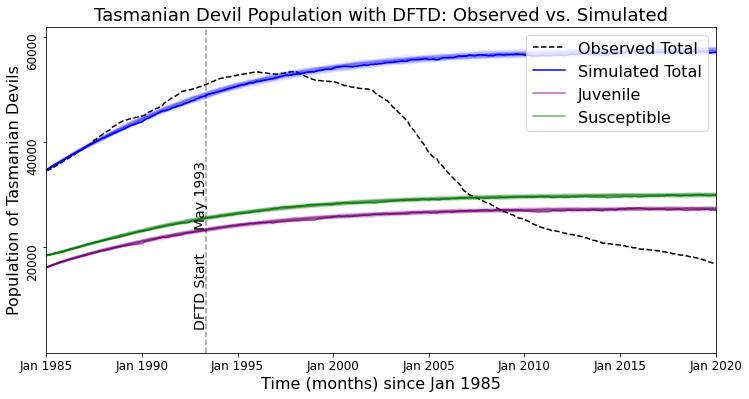

In [10]:
plot_eresult(eresults)

Number of Devils 57019.0 at simulation end, 92.2% of target carrying capacity


/var/folders/z4/bqpnd_kx7xg3s3c9jtz0pnfh0000gn/T/ipykernel_2747/527079870.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


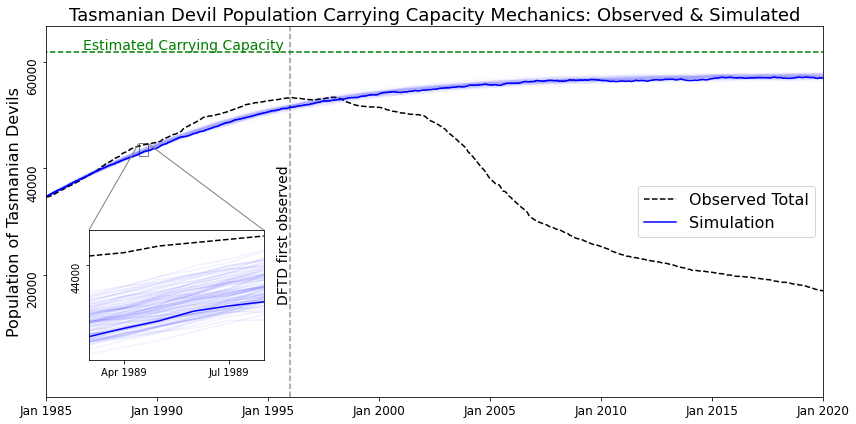

In [11]:
result = eresults
fig, ax1 = plt.subplots(figsize=[12, 6])

plt.title("Tasmanian Devil Population Carrying Capacity Mechanics: Observed & Simulated", fontsize=18)
ax1.set_ylabel("Population of Tasmanian Devils", fontsize=16)
ax1.plot([132, 132], [-3000, max(devil_pop)*1.25], '--k', alpha=0.4)
ax1.plot([-15, result[0]['time'][-1] + 15], [carry_cap, carry_cap], '--g')
ax1.text(20, carry_cap + 500, "Estimated Carrying Capacity", color="green", fontsize=14)
ax1.text(125, 15000, "DFTD first observed", rotation="vertical", color="black", fontsize=14)

ax1.plot(range(len(devil_pop)), devil_pop, '--k', label='Observed Total')
ax1.plot(result[0]['Devils'],'b', label="Simulation")

ax1.set_xlim([0, result[0]['time'][-1]])
ax1.set_ylim([-3000, max(devil_pop)*1.25])
ax1.tick_params(axis='x', labelsize=12)

x_ticks = list(range(0, 421, 60))
x_ticklabels = []
for i in x_ticks:
    x_ticklabels.append(dates[i])

ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_ticklabels)
ax1.set_yticks([20000,40000,60000])
ax1.tick_params(axis='y',labelsize=12, labelrotation=90)
ax1.legend(loc='center right', fontsize=16)

for n,r in enumerate(result):
    if n==0: continue
    ax1.plot(result[n]['Devils'],'b', alpha=0.01)

ax2 = plt.axes([0,0,1,1])
# Manually set the position and relative size of the inset axes within ax1
ip = InsetPosition(ax1, [0.055,0.1,0.225,0.35])
ax2.set_axes_locator(ip)
# Mark the region corresponding to the inset axes on ax1 and draw lines
# in grey linking the two axes.
mark_inset(ax1, ax2, loc1=2, loc2=1, fc="none", ec='0.5')

# plot in the inset
inst=50
ined=56
ax2.plot(range(len(devil_pop))[inst:ined], devil_pop[inst:ined], '--k', label='Observed Total')
ax2.plot(result[0]['time'][inst:ined], result[0]['Devils'][inst:ined],'b', label="Simulation")
ax2.set_xticks([inst+1, ined-2])
ax2.set_xticklabels([dates[inst+1], dates[ined-2]])
ax2.set_xlim(inst,ined-1)
ax2.set_yticks([44000,45000,46000])
ax2.tick_params(axis='y', labelrotation=90)

for n,r in enumerate(result):
    if n==0: continue
    ax2.plot(result[n]['time'][inst:ined], result[n]['Devils'][inst:ined],'b', alpha=0.05)

fig.tight_layout()
# plt.savefig("figures/figure3A.pdf")

final_devil_pop = result[0]['Devils'][-1]

print(f"Number of Devils {final_devil_pop} at simulation end,",
      f"{final_devil_pop/carry_cap*100:.1f}% of target carrying capacity")

## Plots for Figure 14 A

### Check the non-DFTD parameters

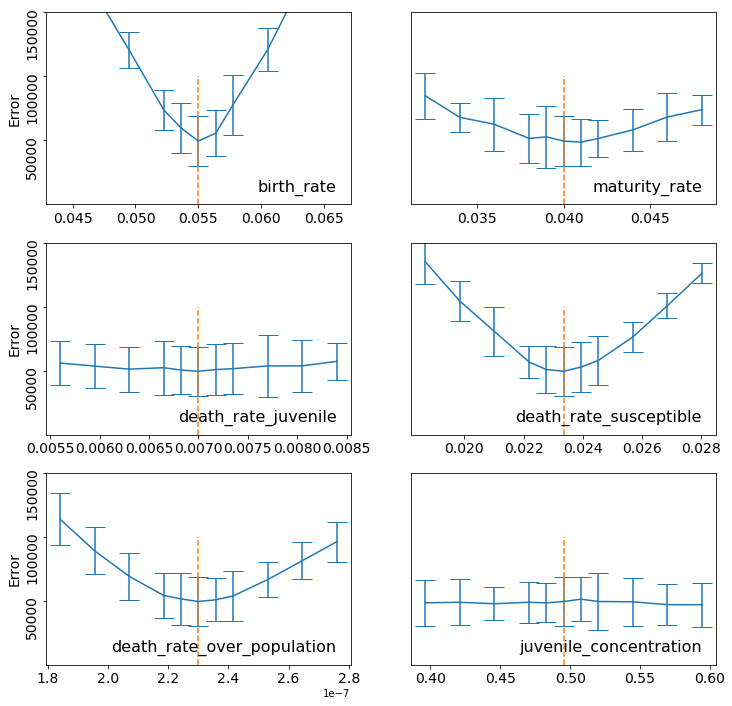

In [12]:
plt.figure(figsize=[12, 12])
pltcnt=1
plot_sweep('birth_rate',3, 2, pltcnt, 150000, [50000, 100000, 150000]);pltcnt+=1
plot_sweep('maturity_rate',3, 2, pltcnt, 150000, [50000, 100000, 150000]);pltcnt+=1
plot_sweep('death_rate_juvenile',3, 2, pltcnt, 150000, [50000, 100000, 150000]);pltcnt+=1
plot_sweep('death_rate_susceptible',3, 2, pltcnt, 150000, [50000, 100000, 150000]);pltcnt+=1
plot_sweep('death_rate_over_population',3, 2, pltcnt, 150000, [50000, 100000, 150000]);pltcnt+=1
plot_sweep('juvenile_concentration',3, 2, pltcnt, 150000, [50000, 100000, 150000]);pltcnt+=1
# plt.savefig("figures/figure4A.pdf")